In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import numpy as np
from simplification.cutil import simplify_coords
from scipy.spatial import cKDTree
import math
from tqdm import tqdm
from dtaidistance import dtw_ndim, dtw_ndim_visualisation
from multiprocessing import Pool, cpu_count

In [2]:
from env import rides_data_path, stops_definition_path, clean_and_filtered_data_path, distance_matrix_dir

# Erstelle Distanzmatrix-Dateien um die ähnlichkeit der Strecken miteinander zu vergleichen.

Lade die Daten und filter nicht valide Daten raus

In [3]:
df = pd.read_csv(rides_data_path)

In [4]:
filtered = df.copy()[(df != 0).all(axis=1)]

In [5]:
filtered[['start_longitude', 'start_latitude', 'end_longitude', 'end_latitude']] = filtered[['start_longitude', 'start_latitude', 'end_longitude', 'end_latitude']].apply(np.abs)

Cluster alle Start- sowie alle Endpunkte, um die Daten nach Start und Ende zu gruppieren.

In [6]:
start_dbscan = DBSCAN(eps=0.001, min_samples=50).fit(filtered[['start_longitude', 'start_latitude']])
end_dbscan = DBSCAN(eps=0.001, min_samples=50).fit(filtered[['end_longitude', 'end_latitude']])

In [7]:
print("Start Estimated number of clusters: %d" % (len(set(start_dbscan.labels_)) - (1 if -1 in start_dbscan.labels_ else 0)))
print("Start Estimated number of noise points: %d" % list(start_dbscan.labels_).count(-1))

print("End Estimated number of clusters: %d" % (len(set(end_dbscan.labels_)) - (1 if -1 in end_dbscan.labels_ else 0)))
print("End Estimated number of noise points: %d" % list(end_dbscan.labels_).count(-1))

Start Estimated number of clusters: 21
Start Estimated number of noise points: 1940
End Estimated number of clusters: 21
End Estimated number of noise points: 1949


In [8]:
filtered['start_label'] = start_dbscan.labels_
filtered['end_label'] = end_dbscan.labels_

Für jede Gruppe erstelle den Mittelwert des Start- und Endpunkts, um den jeweiligen Gruppen eine Station zuzuordnen.

In [9]:
start_mean = filtered.groupby('start_label')[['start_latitude', 'start_longitude']].mean()
end_mean = filtered.groupby('end_label')[['end_latitude', 'end_longitude']].mean()

In [10]:
stops = pd.read_json(stops_definition_path)

In [11]:
tree = cKDTree(stops[['lat', 'lon']].values)

_, indices = tree.query(start_mean[['start_latitude', 'start_longitude']].values)
start_mean['start_nearest_stop'] = stops.loc[indices, 'name'].values

_, indices = tree.query(end_mean[['end_latitude', 'end_longitude']].values)
end_mean['end_nearest_stop'] = stops.loc[indices, 'name'].values

In [12]:
filtered

,start_latitude,start_longitude,end_latitude,end_longitude,line,ziel,ziel_short,ride_id,start_label,end_label
0,54.816011,9.472168,54.785993,9.437128,3,20,20,1,0,0
1,54.815953,9.472250,54.782877,9.440538,3,20,20,2,0,0
2,54.815905,9.472249,54.786027,9.437184,3,20,20,3,0,0
3,54.815984,9.472205,54.786502,9.437008,3,20,20,4,0,0
4,54.816028,9.471967,54.786435,9.436982,3,20,20,5,0,0
...,...,...,...,...,...,...,...,...,...,...
31328,54.791449,9.418343,54.805921,9.428090,4,907,907,34381,11,-1
31329,54.805641,9.428164,54.805968,9.428077,4,907,907,34382,-1,-1
31330,54.803644,9.433201,54.813463,9.421793,1,907,907,34385,-1,4
31331,54.804969,9.412782,54.805453,9.407835,4,911,911,34411,-1,13


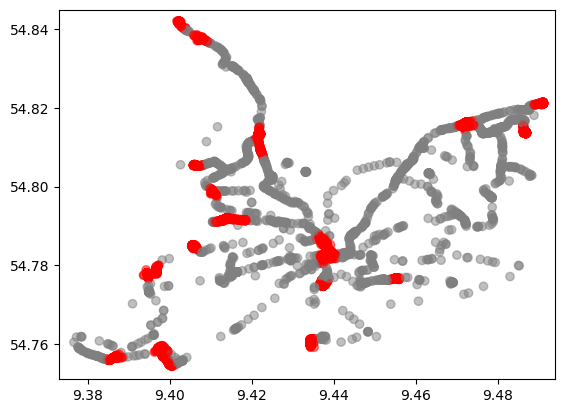

In [13]:
import matplotlib.pyplot as plt
c = filtered['start_label'].map(lambda x: 'red' if x != -1 else 'gray')

plt.scatter(x=filtered['start_longitude'], y=filtered['start_latitude'], c=c, alpha=0.5)
plt.xlim(9.373, 9.494)
plt.ylim(54.751, 54.845)
plt.show()

In [13]:
start_mean

,start_latitude,start_longitude,start_nearest_stop
start_label,,,
-1,54.794981,9.440760,Ballastbrücke
0,54.815870,9.472287,Twedter Plack
1,54.785648,9.437581,ZOB
2,54.774819,9.437271,Bahnhof
3,54.813214,9.421700,Am Lachsbach
4,54.809208,9.422183,Ostseebadweg
5,54.791764,9.413722,Marienhölzungsweg
6,54.841833,9.402205,Krusau DK
7,54.837725,9.407460,Kupfermühle Grenze


In [14]:
end_mean

,end_latitude,end_longitude,end_nearest_stop
end_label,,,
-1,54.791157,9.435519,Fördebrücke
0,54.785509,9.437714,ZOB
1,54.841822,9.402232,Krusau DK
2,54.837757,9.407419,Kupfermühle Grenze
3,54.802167,9.424750,Terrassenstraße
4,54.812899,9.421755,Am Lachsbach
5,54.813932,9.486525,Tremmerup
6,54.813861,9.476612,Marrensberg
7,54.775024,9.437284,Bahnhof


In [15]:
merged = filtered.merge(end_mean['end_nearest_stop'], left_on='end_label', right_index=True)
merged = merged.merge(start_mean['start_nearest_stop'], left_on='start_label', right_index=True)

In [16]:
merged

,start_latitude,start_longitude,end_latitude,end_longitude,line,ziel,ziel_short,ride_id,start_label,end_label,end_nearest_stop,start_nearest_stop
0,54.816011,9.472168,54.785993,9.437128,3,20,20,1,0,0,ZOB,Twedter Plack
1,54.815953,9.472250,54.782877,9.440538,3,20,20,2,0,0,ZOB,Twedter Plack
2,54.815905,9.472249,54.786027,9.437184,3,20,20,3,0,0,ZOB,Twedter Plack
3,54.815984,9.472205,54.786502,9.437008,3,20,20,4,0,0,ZOB,Twedter Plack
4,54.816028,9.471967,54.786435,9.436982,3,20,20,5,0,0,ZOB,Twedter Plack
...,...,...,...,...,...,...,...,...,...,...,...,...
31328,54.791449,9.418343,54.805921,9.428090,4,907,907,34381,11,-1,Fördebrücke,Flurstraße
31329,54.805641,9.428164,54.805968,9.428077,4,907,907,34382,-1,-1,Fördebrücke,Ballastbrücke
31330,54.803644,9.433201,54.813463,9.421793,1,907,907,34385,-1,4,Am Lachsbach,Ballastbrücke
31331,54.804969,9.412782,54.805453,9.407835,4,911,911,34411,-1,13,Frösleeweg,Ballastbrücke


Filtere alle Gruppen heraus, die weniger als 100 Fahrten beinhalten.

In [18]:
label_threshold = merged.groupby(['start_label', 'end_label']).size().reset_index(name='counts').query('counts > 100')
filtered_label_combinations = label_threshold.query("start_label != -1 and end_label != -1")
filtered_label_combinations

,start_label,end_label,counts
25,0,4,131
33,0,16,476
34,0,17,756
35,0,18,1666
38,1,0,952
40,1,2,115
42,1,4,761
48,1,11,238
56,1,19,1372
57,1,20,1124


In [19]:
merged['group_size'] = merged.groupby(['start_nearest_stop', 'end_nearest_stop']).transform('size')
merged_filtered_group_size = merged[merged.group_size > 100]

In [35]:
distribution = merged_filtered_group_size.groupby(['start_nearest_stop', 'end_nearest_stop'])['line'].value_counts()
distribution

start_nearest_stop  end_nearest_stop  line
Am Lachsbach        Bahnhof           1       1281
                                      7        146
                    Fördebrücke       7         53
                                      1         47
                                      2         12
                                              ... 
ZOB                 ZOB               7          1
                                      11         1
                                      100        1
                                      826        1
                                      9998       1
Name: count, Length: 173, dtype: int64

Zeige, welche Linien auf den jeweiligen Gruppen fahren.

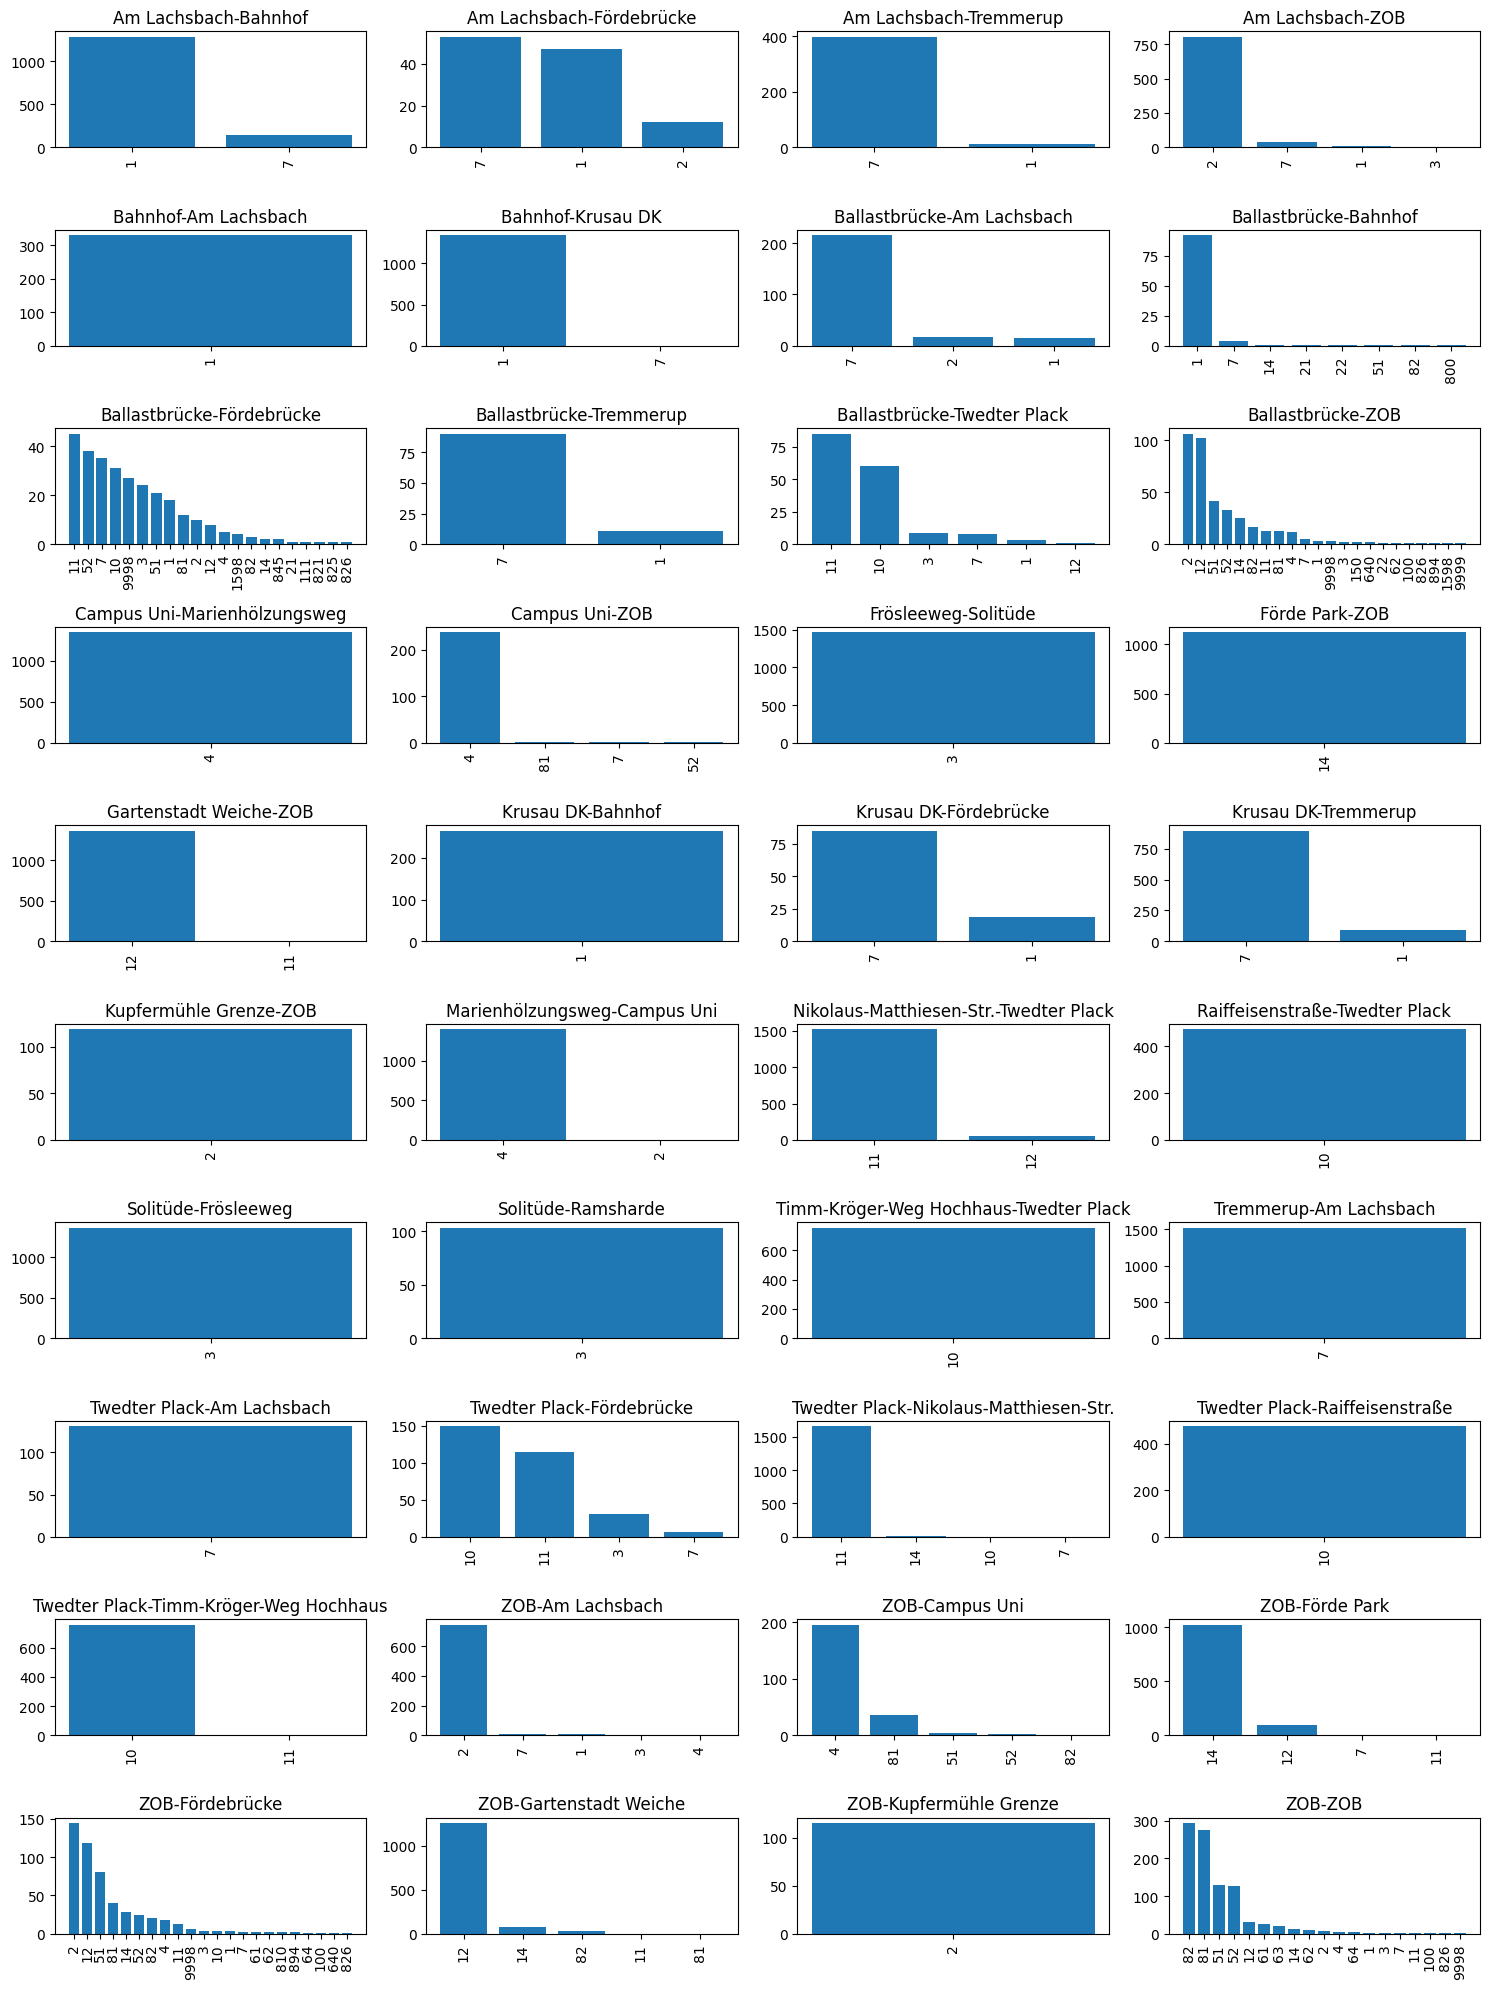

In [36]:
n_groups = len(distribution.groupby(['start_nearest_stop', 'end_nearest_stop']))
n_columns = 4
n = math.ceil(n_groups / n_columns)

fig, axes = plt.subplots(n, n_columns, figsize=(15, 20))
axes = axes.flatten()

for idx, (i, x) in enumerate(distribution.groupby(['start_nearest_stop', 'end_nearest_stop'])):
    line = list(map(lambda l: l[2], x.index.values))
    axes[idx].set_title(f'{i[0]}-{i[1]}')
    axes[idx].bar(x=list(map(str, line)), height=x.values)
    axes[idx].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
everything = pd.read_csv(
    clean_and_filtered_data_path,
    usecols=['vehicle_id', 'status', 'latitude', 'longitude', 'last_modified', 'pdop', 'line', 'ziel', 'ziel_short', 'ride_id'],
    parse_dates=['last_modified'],
)

In [39]:
def simpli(x, epsilon):
    result_array = simplify_coords(x, epsilon)
    return pd.DataFrame(result_array)

Berechne alle Distanzmatrizen und speichere sie. Zur berechnung wird der DTW-Algorithmus benutzt.
> Dieser Schritt kann einige Zeit dauern.

In [ ]:
all_distance_matrix = []

def calculate_distance(df1, df2):
    series1 = df1[[0, 1]].to_numpy()
    series2 = df2[[0, 1]].to_numpy()
    d = dtw_ndim.distance(series1, series2)
    return d

def hafy_comp(label_combination):

    rides_ids = merged.query(f"start_label == {label_combination['start_label']} and end_label == {label_combination['end_label']}")['ride_id'].values
    dataset = everything[everything['ride_id'].isin(rides_ids)]

    simplified_coordinates = (dataset.groupby('ride_id').apply(lambda group: simpli(group[['latitude', 'longitude']].to_numpy(), .001), include_groups=False))


    sc = pd.DataFrame(simplified_coordinates).reset_index()
    distance_ride_ids = sc['ride_id'].unique()

    distance_matrix = pd.DataFrame(index=distance_ride_ids, columns=distance_ride_ids)

    for i, id1 in enumerate(distance_ride_ids):
        for j, id2 in enumerate(distance_ride_ids[i:], start=i):
            df1 = sc[sc['ride_id'] == id1]
            df2 = sc[sc['ride_id'] == id2]
            distance = calculate_distance(df1, df2)
            distance_matrix.loc[id1, id2] = distance
            distance_matrix.loc[id2, id1] = distance

    distance_matrix.to_csv(distance_matrix_dir.joinpath(f'distance_matrix-{label_combination[['start_label', 'end_label']].values}.csv'))
    print("return", label_combination[['start_label', 'end_label']].values)
    return {
        "id": label_combination[['start_label', 'end_label']],
        "matrix": distance_matrix
    }

with Pool(cpu_count()) as pool:
    results = list(tqdm(pool.imap(hafy_comp, [label_combination for index, label_combination in filtered_label_combinations.iterrows()]), total=len(filtered_label_combinations)))
print(results)
print('finish')

Nach diesem Schritt sollten alle Distanzmatrizen erstellt sein, und es kann mit dem nächsten Preprocessing-Schritt weitergehen.

In [ ]:
results